<a href="https://colab.research.google.com/github/adarevalin/Modelos_Lenguaje_Natural/blob/main/ANALISIS_DE_SENTIMIENTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ANÁLISIS DE SENTIMIENTO


Vamos a realizar un análisis de sentimiento utilizando en conjunto de datos de "Conjunto de datos de opinión multidominio (versión 2.0)" ubicados en la pagina https://www.cs.jhu.edu/~mdredze/datasets/sentiment/ en el cual encontraremos datos de opiniones multidominio contiene reseñas de productos tomadas de Amazon.com de muchos tipos de productos (dominios).

#Objetivo generales

* Entender el conjunto de datos utilizado con el fin de maximizar el análisis posterios de caracteristicas.
* Realizar una extracción de las caractetisticas que vamos a utilizar para entrenar los modelos.
*  consultar diferentes algoritmos de clasificación con el fin de obtener un buen rendimiento.
* validación de los modelos con metricas de prueba.

## Objetivos específicos

* Cargar el corpus y extraer los datos.
* Realizar limpeza de los datos para obtener textos o tokens de interes.
* Realizar una extracción de caracteristicas utilizando vectorización, colocaciones o la tecnica que mejor se adapte a nuestro problema.
* Entrenar y validar los modelos de aprendizaje automatico.

##**Problema**

Tenemos que realizar un modelo de inteligencia artificial que me permita clasificar la opinión de un documento (reseñas) como negativas o positivas, esto se va a realizar utilizando "0" para negativo y "1" para positivo, entonces en base a las reseñas y comentarios dejados vamos a interpretarlos y conseguir que el modelo determine que tanto gusto un dominio o no.

# Carga de corpus y extraer datos

nota: Puesto que el formato de archivo GZ sirve para comprimir y guardar varios archivos en uno, se utiliza principalmente para entregar archivos comprimidos, programas o instaladores en línea o simplemente para almacenar archivos localmente.

In [1]:
## Librerias que vamos utilizando
import tensorflow as tf
import numpy as np
from random import shuffle # generar aletoriedad en los set
from sklearn.model_selection import train_test_split # para separar los set
from urllib import request # para obtener el archivo tar.gz
import matplotlib.pyplot as plt # para graficar
from IPython import display


In [2]:
import nltk, random # necesaria para tokenizar y random nos permite generar aletoriedad en los datos.
nltk.download('punkt')  # Descarga de recursos para tokenización, ejecutar solo una vez

from nltk import word_tokenize  # Tokenización de palabras

from nltk.corpus import stopwords
nltk.download('stopwords')  # Descarga de recursos para palabras vacías, ejecutar solo una vez
stop_words = set(stopwords.words('english'))
from nltk.util import bigrams # importar de nltk los bigrams
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
request.urlretrieve("http://www.cs.jhu.edu/~mdredze/datasets/sentiment/processed_acl.tar.gz", "processed_acl.tar.gz") # obtenemos el archivo de internet


('processed_acl.tar.gz', <http.client.HTTPMessage at 0x7bacab0a0a90>)

In [4]:
!tar xvzf processed_acl.tar.gz # para cargar lso datos en el entorno de trabajo

processed_acl/
processed_acl/dvd/
processed_acl/dvd/negative.review
processed_acl/dvd/unlabeled.review
processed_acl/dvd/positive.review
processed_acl/books/
processed_acl/books/negative.review
processed_acl/books/unlabeled.review
processed_acl/books/positive.review
processed_acl/kitchen/
processed_acl/kitchen/negative.review
processed_acl/kitchen/unlabeled.review
processed_acl/kitchen/positive.review
processed_acl/electronics/
processed_acl/electronics/negative.review
processed_acl/electronics/unlabeled.review
processed_acl/electronics/positive.review


Se crea una función que va a extraer los datos.

nota. Formato de archivo REVIEW: Cada archivo tiene un formato de archivo definido, es decir, cómo se organizan los datos en el archivo. Los primeros caracteres de un archivo identifican el formato del archivo, por ejemplo, los archivos html comienzan con los bytes <html>. 10% de todos los archivos REVIEW comienzan con los bytes mágicos avid:1 your:1 horrible_book:1 wasted:1 use_it:1 the_entire, que son siempre los primeros bytes de este formato de archivo. Estos archivos son texto sin formato.  Casi siempre se encuentran algunas palabras en los archivos, como avid:1 your:1 horrible_book:1 wasted:1 use_it:1 the_entire:1 money.i:1 i_lit:1 i_read:1 lit:1 i_would:1 relationship:1 read:1 a_<num>:1 reader_and:1 reader:1 suffering:1 fire_one:1 i_had:1 year_old:2. El siguiente nombre de archivo es común: negative.review.

In [5]:
# Estas expresiones regulares me ayudan hacer busquedas y filtrar las palabras importantes.

pattern = r'''(?x)                 # establecer bandera para permitir expresiones regulares detalladas
              (?:[A-Z]\.)+         # abreviaturas, ejemplo (U.S.A.)
              |\w+(?:-\w+)*       # palabras con guiones internos opcionales
              |\$?\d+(?:\.\d+)?%? # moneda y porcentajes, ejemplo ($12.40, 82%)
              |\.\.\.             # elipsis
              |[][.,;"'?():-_`]   # éstas son fichas separadas; incluye ], [
'''

In [6]:
# esta funcion realiza el proceso de tokenizar, limpiar y obtener las raices de las palabras
def lemetizar (tokens):
    # Filtrar palabras: eliminar stopwords y palabras con longitud menor o igual a 3, excepto las dos últimas
    stop_words_filtered = [palabra for palabra in tokens if palabra.lower() not in stop_words and len(palabra) > 3]#[:-2]

    # Filtrar palabras con formato palabra:número
    words_number_filtered = [word for word in stop_words_filtered if ':' not in word]

    # Filtrar y separar las palabras de '_'
    words_point = [word.split('_') for word in tokens]
    words_point_filtered = []
    for sublist in words_point:
        words_point_filtered.extend(sublist)

    # Filtrar y separar las palabras de '-'
    words_point_2 = []
    for word in words_point_filtered:
        words_point_2.extend(word.split('-'))


    stopWords_filtered = [word for word in words_point_2 if word not in stop_words and len(word) > 3]

    lemmatized_words = [lemmatizer.lemmatize(word) for word in stopWords_filtered]  # Lematización

    return lemmatized_words # obtenemos raices de cada palabra

Debemos crear una función que realice el pre-procesamiento de los datos.

In [7]:

def preprocess(filename):

    with open(filename, 'r') as f: # with muy importante para cerrar archivos binarios
        raw_text = f.read() # leemos los archivos del .tar
        raw_text = raw_text.split('\n') # cuando tenemos un salto de linea, el text hace una separacion, esto lo podemos ver gracias a la estructura del texto

        processed_words = []
        Set_words = []

        for text in raw_text:
            if text.strip():
                tokens = nltk.regexp_tokenize(text, pattern)  # Tokeniza y realiza filtro con expresiones regulares

                lemaWords = lemetizar(tokens) # utilizamos la funcion para limpieza

                for LWords in lemaWords:
                    #if LWords not in Set_words:
                    Set_words.append(LWords)


                # Determinar el label
                label = 0 if lemaWords[-1] == 'negative' else 1

                # Agregar las palabras procesadas al conjunto
                processed_words.append((lemaWords, label))


    return processed_words, Set_words

Se crean las lista tanto de positivos como de negativos y el set de palabras de cada uno `Tener presente que los datos se estan utilizando son de libros`

In [8]:
negative_words_set, Set_words_negative = preprocess('/content/processed_acl/books/negative.review') # datos negtivos
positive_words_set, Set_words_positive = preprocess('/content/processed_acl/books/positive.review') # datos positivos


Vamos a encontrar las palabras mas valiosas de cada set, para hacer esto creamos una función que me permite comparar y eliminar palabras que se compartan en las dos lista dejando solo palabras valiosas para cada set, diferenciales.

In [9]:
def eliminar_palabras_comunes(lista1, lista2): # cargamos las dos listas
    set_lista1 = set(lista1) # filtramos valores unicos
    set_lista2 = set(lista2) # filtramos valores unicos

    palabras_en_lista1_solo = set_lista1 - set_lista2 # esto es importante restamos la lista 1 de la lista 2

    return list(palabras_en_lista1_solo)

top_Words_neg = eliminar_palabras_comunes(Set_words_negative, Set_words_positive) # se componen de 6006
top_Words_pos = eliminar_palabras_comunes(Set_words_positive, Set_words_negative)

#Nota. obtenemos lista utiles y balanceadas para cada label

In [10]:
len(top_Words_neg)

6006

In [11]:
len(top_Words_pos)

6192

In [12]:
List_Words = top_Words_neg + top_Words_pos ## Unimos las dos listas una sola la cual vamos a utilizar mas adelante para comparar

Vamos a procesar  las listas de los set y crear n-gramas, filtrando y dejando como los `trigramas` que tengan palabras de los top_words tanto para etiquetas positivas como etiquetas negativas.

In [13]:
def procesar_ngramas(words_set, top_words): # cargamos los set de los documentos y sus palabras y la lista de top palabras de cada uno
    Data = []
    for lista, label in words_set: # extraemos cada reseña y cargamos las palabras
        processed = []
        for palabra in lista: # miramos cada palabra
            if palabra in top_words: # verificamos si la palabra esta en las top_words
                processed.append(palabra) # si esta añadimos la palabra a una lista interna

        processed = list(set(processed)) # Eliminar duplicados usando un conjunto
        if processed:  # Verificar si la lista no está vacía
            Data.append((processed, label)) # añadimos la lista a un set

    return Data

negative_top = procesar_ngramas(negative_words_set, top_Words_neg) # obtenemos una lista con palabras importantes y sus etiquetas
positive_top = procesar_ngramas(positive_words_set, top_Words_pos)


In [14]:
# Crear trigramas con NLTK
from nltk.util import ngrams

def crear_trigramas(data):
    trigramas = []
    for words, label in data: # separamos los datos y sus etiquetas
        trigramas.extend([(ngram, label) for ngram in list(nltk.ngrams(words, 3))]) #Creamos trigramas para eso se miran todos los posibles casos con las palabras de data
    return trigramas # añadimos esos trigramas y etiquetas

# Procesar los n-gramas de las palabras positivas
negative_trigrams = crear_trigramas(negative_top)
positive_trigrams = crear_trigramas(positive_top) # obtenemos casi 6000 trigrams

Nota. en este arreglo tenemos los trigramas mas relevantes, junto con sus etiquetas y todos los datos dispersos de manera aleatoria

In [15]:
Datos = negative_trigrams + positive_trigrams
random.shuffle(Datos) # con la funcion random creamos aletoriedad.

# Empezamos el procesamiento de los datos, vectorización, codificación y padding


Se codifica todas las palabras tanto negativas como positivas, se realiza un proceso de padding para crear un array homogeneo
y tambien obtenemos las etiquetas.

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

#El grupo de palabras se crea en base a la frecuencia al poner corpus fit_ontexts().
## ESTE TOKENIZADOR ENTRENADO ES IMPORTANTE PORQUE CUENTA CON LA LISTA DE TODAS LAS PALABRAS CODIFICADAS##

tokenizer = Tokenizer() # instanciamos
tokenizer.fit_on_texts(List_Words) # pasamos todas la palabras relevantes que estan en el data y las codificamos

def encoded (sentence):

    code = tokenizer.texts_to_sequences(sentence) #vamos codificando cada trigrama

    return code

In [17]:
Encoded = []
Label = []

for word, label in Datos: # cargamos nuestros datos

    if word: # verificamos si no esta vacio
        WordCode = encoded(word) # pasamos cada trigrama para codificar
        if len(WordCode) == 3 and WordCode != None: # verififcamos que tenga lungitud de 3 y no este vacio
            Code = []
            for palabra in WordCode: #obtenemos cada palabra para crear una lista
                Code.extend(palabra) # pasamos toda la lista con formato [1,2,3]
            Encoded.append(Code) #pasamos la lista para crear una lista de listas
            Label.append(label) # agregamos su etiqueta

#Obtener las longitudes de todas las secuencias en todas las sublistas
sequence_lengths = max([len(sublist) for sublist in Encoded]) # max es 3


In [18]:
padded = []
for item in Encoded: # Para cada lista
    while len(item) < sequence_lengths: # mientras sea menor que la lungitud maxima
        item.append(0) # agregamos ceros para normaizar
    padded.append(item)  # agregamos la lista


In [19]:
X = np.array(padded) # creamos una matriz de datos
y = Label # y sus etiquetas

# Entrenamiento y visualización de los datos

## Entrenamiento con DecisionTreeClassifier

In [20]:
# prompt: split de train y test con sklearn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [21]:
# prompt: arbol de decision para x_train

from sklearn.tree import DecisionTreeClassifier

arbol = DecisionTreeClassifier()
arbol.fit(X_train, y_train)


DecisionTreeClassifier()

In [22]:
# prompt: quiero  ver las matricas de decempeño con el X_test

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = arbol.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])


Predicted,0,1
Actual,,
0,1177,0
1,0,1329


In [23]:
# prompt: quiero e accuracy

from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 1.0


In [24]:
# prompt: quiero la precision

print("Precision:", metrics.precision_score(y_test, y_pred))


Precision: 1.0


In [25]:
# prompt: quiero la metrica de recall

print("Recall:", metrics.recall_score(y_test, y_pred))


Recall: 1.0


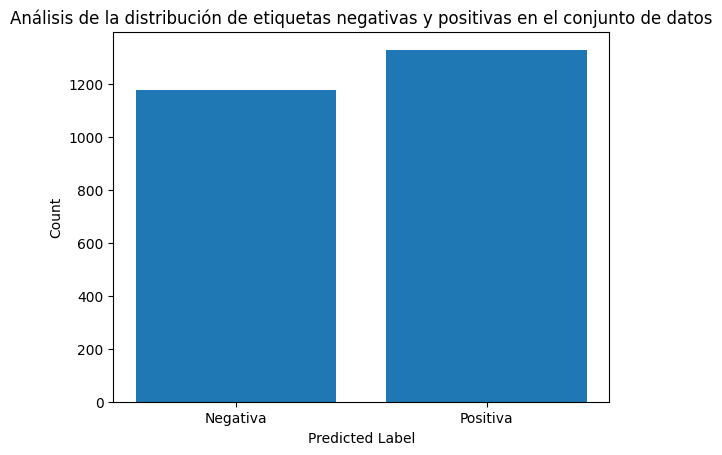

In [26]:
# prompt: generar graficalos X_predichos en funcion de las etiquetas

import matplotlib.pyplot as plt
# Create a list of predicted labels
predicted_labels = ['Positive' if pred == 1 else 'Negative' for pred in y_pred]

# Contamos la cantidad de veces que ocurren las etiquetas
count_1 = np.count_nonzero(y_pred == 1)
count_0 = np.count_nonzero(y_pred == 0)

# Creamos un gráfico de barras
plt.bar([1, 0], [count_1, count_0], tick_label=['Positiva', 'Negativa'])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Análisis de la distribución de etiquetas negativas y positivas en el conjunto de datos')

# Show the plot
plt.show()


## Entrenamiento con Naive bayes

Accuracy: 0.9992019154030327
Precision: 0.9984973703981969
Recall: 1.0


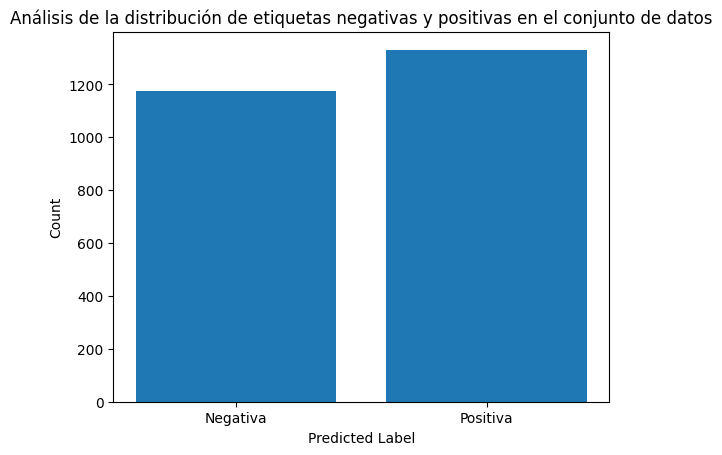

In [27]:
# prompt: clasificador de naive bayes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
modelo_naive = GaussianNB()
modelo_naive.fit(X_train, y_train)

y_pred_naive = modelo_naive.predict(X_test)

cm = confusion_matrix(y_test, y_pred_naive)

pd.crosstab(y_test, y_pred_naive, rownames=['Actual'], colnames=['Predicted'])


print("Accuracy:", metrics.accuracy_score(y_test, y_pred_naive))


print("Precision:", metrics.precision_score(y_test, y_pred_naive))


print("Recall:", metrics.recall_score(y_test, y_pred_naive))


# Create a list of predicted labels
predicted_labels_naive = ['Positive' if pred == 1 else 'Negative' for pred in y_pred_naive]

# Contamos la cantidad de veces que ocurren las etiquetas
count_1_naive = np.count_nonzero(y_pred_naive == 1)
count_0_naive = np.count_nonzero(y_pred_naive == 0)

# Creamos un gráfico de barras
plt.bar([1, 0], [count_1_naive, count_0_naive], tick_label=['Positiva', 'Negativa'])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Análisis de la distribución de etiquetas negativas y positivas en el conjunto de datos')

# Show the plot
plt.show()


## Clasificador con maquinas de soporte vectorial

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


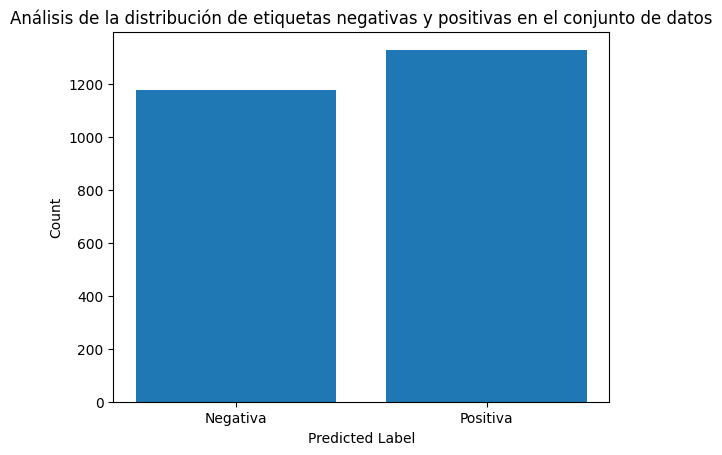

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

modelo_SVM = SVC(kernel='linear')
modelo_SVM.fit(X_train, y_train)

y_pred_SVM = modelo_SVM.predict(X_test)

cm = confusion_matrix(y_test, y_pred_SVM)

pd.crosstab(y_test, y_pred_SVM, rownames=['Actual'], colnames=['Predicted'])


print("Accuracy:", metrics.accuracy_score(y_test, y_pred_SVM))


print("Precision:", metrics.precision_score(y_test, y_pred_SVM))


print("Recall:", metrics.recall_score(y_test, y_pred_SVM))


# Create a list of predicted labels
predicted_labels_SVM = ['Positive' if pred == 1 else 'Negative' for pred in y_pred_SVM]

# Contamos la cantidad de veces que ocurren las etiquetas
count_1_SVM = np.count_nonzero(y_pred_SVM == 1)
count_0_SVM = np.count_nonzero(y_pred_SVM == 0)

# Creamos un gráfico de barras
plt.bar([1, 0], [count_1_SVM, count_0_SVM], tick_label=['Positiva', 'Negativa'])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Análisis de la distribución de etiquetas negativas y positivas en el conjunto de datos')

# Show the plot
plt.show()


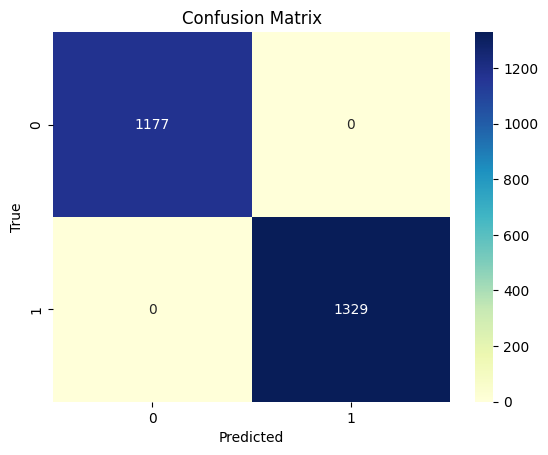

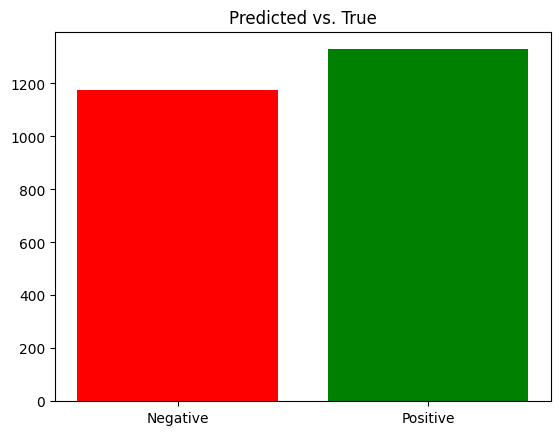

In [38]:
#### FALTA REVISAR ###

import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_test , y_pred_SVM)

# Create a heatmap
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="g")

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Create a bar chart
labels = ['Negative', 'Positive']
x = [1, 2]
y = [cm[0][0], cm[1][1]]

plt.bar(x, y, color=['red', 'green'])
plt.xticks(x, labels)
plt.title('Predicted vs. True')
plt.show()


# Clasificar con datos de los otros review como DVD o electronics para ver el comportamiento utilizando la lista de palabras del `review de book`

In [30]:
negative_words_set_DVD, Set_words_negative_DVD = preprocess('/content/processed_acl/dvd/negative.review') # datos negtivos
positive_words_set_DVD, Set_words_positive_DVD = preprocess('/content/processed_acl/dvd/positive.review') # datos positivos


In [31]:
negative_top_DVD = procesar_ngramas(negative_words_set_DVD, top_Words_neg) # obtenemos una lista con palabras importantes y sus etiquetas
positive_top_DVD = procesar_ngramas(positive_words_set_DVD, top_Words_pos)


In [32]:
# Procesar los n-gramas de las palabras positivas
negative_trigrams_DVD = crear_trigramas(negative_top_DVD)
positive_trigrams_DVD = crear_trigramas(positive_top_DVD) # obtenemos casi 6000 trigrams

In [33]:
Datos_DVD = negative_trigrams_DVD + positive_trigrams_DVD
random.shuffle(Datos_DVD) # con la funcion random creamos aletoriedad.

In [34]:
Encoded_DVD = []
Label_DVD = []

for word, label in Datos_DVD: # cargamos nuestros datos

    if word: # verificamos si no esta vacio
        WordCode = encoded(word) # pasamos cada trigrama para codificar
        if len(WordCode) == 3 and WordCode != None: # verififcamos que tenga lungitud de 3 y no este vacio
            Code = []
            for palabra in WordCode: #obtenemos cada palabra para crear una lista
                Code.extend(palabra) # pasamos toda la lista con formato [1,2,3]
            Encoded_DVD.append(Code) #pasamos la lista para crear una lista de listas
            Label_DVD.append(label) # agregamos su etiqueta

#Obtener las longitudes de todas las secuencias en todas las sublistas
sequence_lengths = max([len(sublist) for sublist in Encoded_DVD]) # max es 3

In [35]:
padded_DVD = []
for item in Encoded_DVD: # Para cada lista
    while len(item) < sequence_lengths+1: # mientras sea menor que la lungitud maxima
        item.append(0) # agregamos ceros para normaizar
    padded_DVD.append(item)  # agregamos la lista


In [36]:
X_DVD = np.array(padded_DVD) # creamos una matriz de datos
y_DVD = Label_DVD # y sus etiquetas

In [37]:
y_pred_DVD = arbol.predict(X_DVD)

cm = confusion_matrix(y_DVD, y_pred_DVD)

pd.crosstab(y_DVD, y_pred_DVD, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,1553,0
1,0,1830


<font size="+2">**Podemos observar que con el dataset de DVD los `datos disminuyen ` a 3000 de 10000 pero aun asi alcanzan a distinguir de negativos y positivos**<font>